# Signals Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import multiprocessing
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import matplotlib_venn
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import scipy
from sklearn import tree
import sklearn
from sklearn import cross_validation
sns.set_context('notebook')

In [2]:
workingDirectory = '/home/jtao/analysis/signal_level_analysis/'

if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

## Functions

In [86]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    return sequence_array_list

In [88]:
def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    with open(file_path) as f:
        data = f.readlines()
    id_list = []
    sequence_list = []
    # loop through each sequence
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            sequence_list.append(seq)
    return sequence_list, id_list

In [89]:
def read_motif_file(motifPath, pseudocount):
    '''
    reads all motif files in a directory 
    inputs: path to a directory containing homer motif files
    outputs: an array of tuples representing each motif
    '''
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores = scores + pseudocount
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

In [108]:
def calc_multi_motif_sequence(seq_array, 
                              forward_score_dict, 
                              reverse_score_dict, 
                              motif_size_dict,
                              score_threshold = 0,
                              distance_threshold = 200,
                              symmetric_motifs = []
                             ):
    '''
    '''
    motif_names = sorted(forward_score_dict.keys())
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.DiGraph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(forward_score_dict[motif])))
        forward_scores = forward_score_dict[motif]
        revcomp_scores = reverse_score_dict[motif]

        # identify motif instances using score score_threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>score_threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>score_threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + ' ' + motif + ' +'
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + ' ' + motif + ' -'
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # add edges
    all_nodes = seq_graph.nodes(data=True)
    edges_to_add = []
    for node in all_nodes:
        # find the first nonoverlapping motif(s)
        end_pos = node[1]['end']
        first_neighbor_pos = end_pos
        candidate_neighbors = []
        while len(candidate_neighbors) < 1 and first_neighbor_pos < seq_size:
            candidate_neighbors = position_node_array[first_neighbor_pos]
            first_neighbor_pos += 1
            
        # find largest motif amongst the first nonoverlapping motif(s)
        max_size_end = -1
        max_size_start = -1
        for n in candidate_neighbors:
            neighbor = seq_graph.node[n]
            neighbor_end = neighbor['end']
            neighbor_start = neighbor['start']
            if neighbor_end > max_size_end:
                max_size_end = neighbor_end
                max_size_start = neighbor_start
        # identify all motifs that overlap with the first largest nonoverlapping motif(s)
        for pos in range(max_size_start, max_size_end):
            candidate_neighbors = candidate_neighbors + position_node_array[pos]
        candidate_neighbors = set(candidate_neighbors)
        
        for n in candidate_neighbors:
            neighbor = seq_graph.node[n]
            neighbor_start = neighbor['start']
            if neighbor_start >= end_pos:
                edges_to_add.append((node[0], n))
    seq_graph.add_edges_from(edges_to_add)

    # creat start node and connect all nodes with 0 incoming edges
    start_edges = []
    for node_id, in_degree in seq_graph.in_degree_iter():
        if in_degree == 0:
            start_edges.append(('start', node_id))
            
    # create end node and connect all nodes with 0 outgoing edges
    end_edges = []
    for node_id, out_degree in seq_graph.out_degree_iter():
        if out_degree == 0:
            end_edges.append((node_id, 'end'))
    
    if len(start_edges) > 1:
        seq_graph.add_edges_from(start_edges)
    else:
        seq_graph.add_node('start')
    if len(end_edges) > 1:
        seq_graph.add_edges_from(end_edges)
    else:
        seq_graph.add_node('end')
    # generate all paths from start to end node
    paths = nx.all_simple_paths(seq_graph, 'start', 'end')
    
    # add data to list of paths
    id_score_dict = nx.get_node_attributes(seq_graph, 'score')
    paths_with_data = []
    paths_without_data = []
    counter = 0
    for p in paths:
        
        if counter > 10000:
            print('Too many paths!!!')
            return seq_graph, [], [] 
        counter += 1
        
        current_p_with_data = []
        current_p_without_data = []
        for n in p:
#             if n == 'start':
#                 motif_name = 'start'
#                 orientation = '|'
#                 score = score_threshold
#             elif n == 'end':
#                 motif_name = 'end'
#                 orientation = '|'
#                 score = score_threshold
#             else:
            # exclude end and start nodes which were created just for creating paths
            if not n== 'start' and not n == 'end':
                tokens = n.split()
                motif_name = tokens[1]
                orientation = tokens[2]
                score = id_score_dict[n]
                
                n_with_data = (motif_name, orientation, score)
                current_p_with_data.append(n_with_data)
                current_p_without_data.append(motif_name + ' ' + orientation)
        paths_with_data.append(current_p_with_data)
        paths_without_data.append(current_p_without_data)

    return seq_graph, paths_with_data, paths_without_data

In [113]:
def motif_prefix_span(prefix, database, support_level):
    '''
    Finds frequents sequences of motifs in a datase of sequences and their corresponding
    motif paths
    inputs: prefix - a string representing a motif and its orientation
            database - a dictionary containing lists of motif paths corresponding to each sequence
            support level - number of times a motif must appear to be counted
    outputs: a list of frequent patterns
    '''
#     print('***', prefix, len(database))
    if len(database) >= support_level:
        frequent_motifs = find_frequent_motifs(database, support_level)
    else:
        frequent_motifs = []
    to_return = []
    if len(frequent_motifs) > 0:
        for fm in frequent_motifs:
            new_pattern = prefix + [fm]
            projected_database = project_database(fm, database)
            
            fm_results = motif_prefix_span(new_pattern, 
                                           projected_database, 
                                           support_level)
            to_return = to_return +  fm_results 

            to_return.append(new_pattern)
    return to_return

In [114]:
def find_frequent_motifs(database, support_level):
    '''
    Finds motifs in database that exceeds support level. 
    For each sequence, collapses the counts of all motif paths corresponding to that sequence
    
    inputs: database - a dictionary containing lists of motif paths
                      corresponding to each sequence
            support_level - number of times a motif must appear to be counted
    outputs: 
    '''
    motif_count_dict = {}
    
    for seq_id in database:
        motifs_in_seq = set()
        motif_paths = database[seq_id]
        for path in motif_paths:
            for motif in path:
                motifs_in_seq.add(motif)
        for m in motifs_in_seq:
            if m in motif_count_dict:
                motif_count_dict[m] += 1
            else:
                motif_count_dict[m] = 1
    
    frequent_motifs = [(x, motif_count_dict[x]) for x in motif_count_dict if motif_count_dict[x] >= support_level]
    sorted_frequent_motifs = sorted(frequent_motifs, key = lambda x:x[1], reverse=True)
    to_return = [x[0] for x in sorted_frequent_motifs]
#     print(len(database), sorted_frequent_motifs[:10])
    return to_return

In [115]:
def project_database(prefix, database):
    '''
    projects a database of sequences and their corresponding motif paths
    according to a prefix. 
    input: prefix - a string representing a motif and its orientation,
           database - a dictionary containing lists of motif paths
                      corresponding to each sequence
                      {seq_id:[motif_sequences...]}
    output: returns the projected database
    '''
    projected_database = {}
    for seq_id in database:
        projected_paths = []
        motif_paths = database[seq_id]
        for path in motif_paths:
            if prefix in path:
                ind = path.index(prefix)
                proj_path = path[ind+1:]
                if len(proj_path) > 0:
                    projected_paths.append(proj_path)
#         print(prefix, (motif_paths), projected_paths)
        if len(projected_paths) > 0:
            projected_database[seq_id] = projected_paths
        
    return projected_database

In [116]:
def create_pattern_sequence_table(frequent_patterns, 
                                         database):
    '''
    Constructs a matrix summarizing which sequences contains a frequent motif pattern
    '''

    lock = threading.Lock()  
    thread_list = []
    
    has_pattern_dict = {}
    sorted_ids = sorted(database.keys())   

    for i in range(len(frequent_patterns)):
        try:
            pattern = frequent_patterns[i]
            current_thread = threading.Thread(target = find_pattern,
                             args=(pattern,
                                   sorted_ids,
                                   database,
                                   has_pattern_dict,
                                   lock
                                   )      
                            )
            thread_list.append(current_thread)
            current_thread.start()
        finally:
            if lock.locked_lock():
                lock.release()
    for current_thread in thread_list:
        current_thread.join()


    sequence_pattern_table = pd.DataFrame(has_pattern_dict,
                                          index = sorted_ids)
    return sequence_pattern_table

In [117]:
def find_pattern(pattern,
                 sorted_ids,
                 database,
                 result_dict,
                 thread_lock
                 ):
    pattern_name = ' * '.join(pattern)
    has_pattern_list = []
    start = time.time()
    for seq_id in sorted_ids:
        motif_paths = database[seq_id]
        has_pattern = False
        for path in motif_paths:
            path_iter = iter(path)
            has_pattern = all([m in path_iter for m in pattern])
            if has_pattern:
                break
        if has_pattern:
            has_pattern_list.append(1)
        else:
            has_pattern_list.append(0)

    while thread_lock.locked_lock():
        time.sleep(0.05)
    thread_lock.acquire()
    
    result_dict[pattern_name] = has_pattern_list
    print('done searching for', pattern_name, time.time() - start)
    if thread_lock.locked_lock():
        thread_lock.release()



## Data Processing

### ATAC Peaks

In [31]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
peakDirectory = workingDirectory + '/' + 'atac_peak_files'

if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open('./peakCalling_homer_idr.sh', 'w')

atacTagDirPath = './tag_directories_atac/'
for tagDir in os.listdir(atacTagDirPath):
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName1 = tagDir + "_peaks.tsv"

    scriptFile1.write('findPeaks ' + atacTagDirPath + '/' + tagDir 
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 150  > ' + 
                     peakDirectory + '/' + peakFileName1 + ' &\n')
    
scriptFile1.close()




In [32]:
%%bash
rm ./atac_peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer_idr.sh

	Fragment Length = 67
	Total Tags = 12733303.0
	Tags per bp = 0.006367
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Fragment Length = 77
	Total Tags = 9726543.0
	Tags per bp = 0.004863
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Fragment Length = 87
	Total Tags = 3551409.0
	Tags per bp = 0.001776
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Fragment Length = 67
	Total Tags = 5746574.0
	Tags per bp = 0.002873
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
		Finding peaks on chr1 (minCount=-0.7), total tags positions = 170908
		Finding peaks on chr1 (minCount=-0.6), total tags positions = 273690
		Finding peaks on chr1 (minCount=-0.3), total tags positions = 448119
		Finding peaks on chr2 (minCount=-0.7), total tags positions = 160142
		Finding peaks on chr1 (minCount=-0.0), total tags positions = 571010
		Findin

In [34]:
idrDirectory = './atac_idr/'
scriptFile = open('./run_idr.sh', 'w')
!rm ./atac_idr/*

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
replicateIndices = []


# homer peaks
counter = 0
treatments = set([x.split('_')[3] for x in os.listdir(atacTagDirPath)])
for treatment in treatments:
    samples = [ x for x in os.listdir(atacTagDirPath) if treatment in x]
    
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            print(treatment,max_length)
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.01"
            else: 
                commandString += " -threshold 0.05"            
            commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

rm: cannot remove ‘./atac_idr/*’: No such file or directory
Veh 124766
KLA-1h 152283


In [30]:
%%bash
bash ./run_idr.sh

Performing IDR analysis on the following samples: /home/jtao/analysis/signal_level_analysis//atac_peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72_peaks.tsv, /home/jtao/analysis/signal_level_analysis//atac_peak_files/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.02
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples ./atac_idr//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72_peaks.narrowPeak ./atac_idr//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks.narrowPeak --output-file ./atac_idr//C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_idr.out --plot --idr-threshold 0.02 &
Performing IDR analysis on the following samples: /home/jtao/analysis/signal_level_analysis//atac_peak_files/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-2_peaks.tsv, /home/jt

Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [2.06 1.41 0.92 0.61]
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/idr-2.0.2-py3.5-linux-x86_64.egg/idr/idr.py:415: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if localIDRs == None or IDRs == None:
Number of reported peaks - 24073/54727 (44.0%)

Number of peaks passing IDR cutoff of 0.02 - 24073/54727 (44.0%)

/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  narrowPeakFrame['pValue'] = -1
Final parameter values: [2.64 1.64 0.96 0.66]
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site

C57Bl6_Thiomac_ATAC_KLA-1h
C57Bl6_Thiomac_ATAC_Veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: FutureWarning: sort(....) is deprecated, use sort_index(.....)


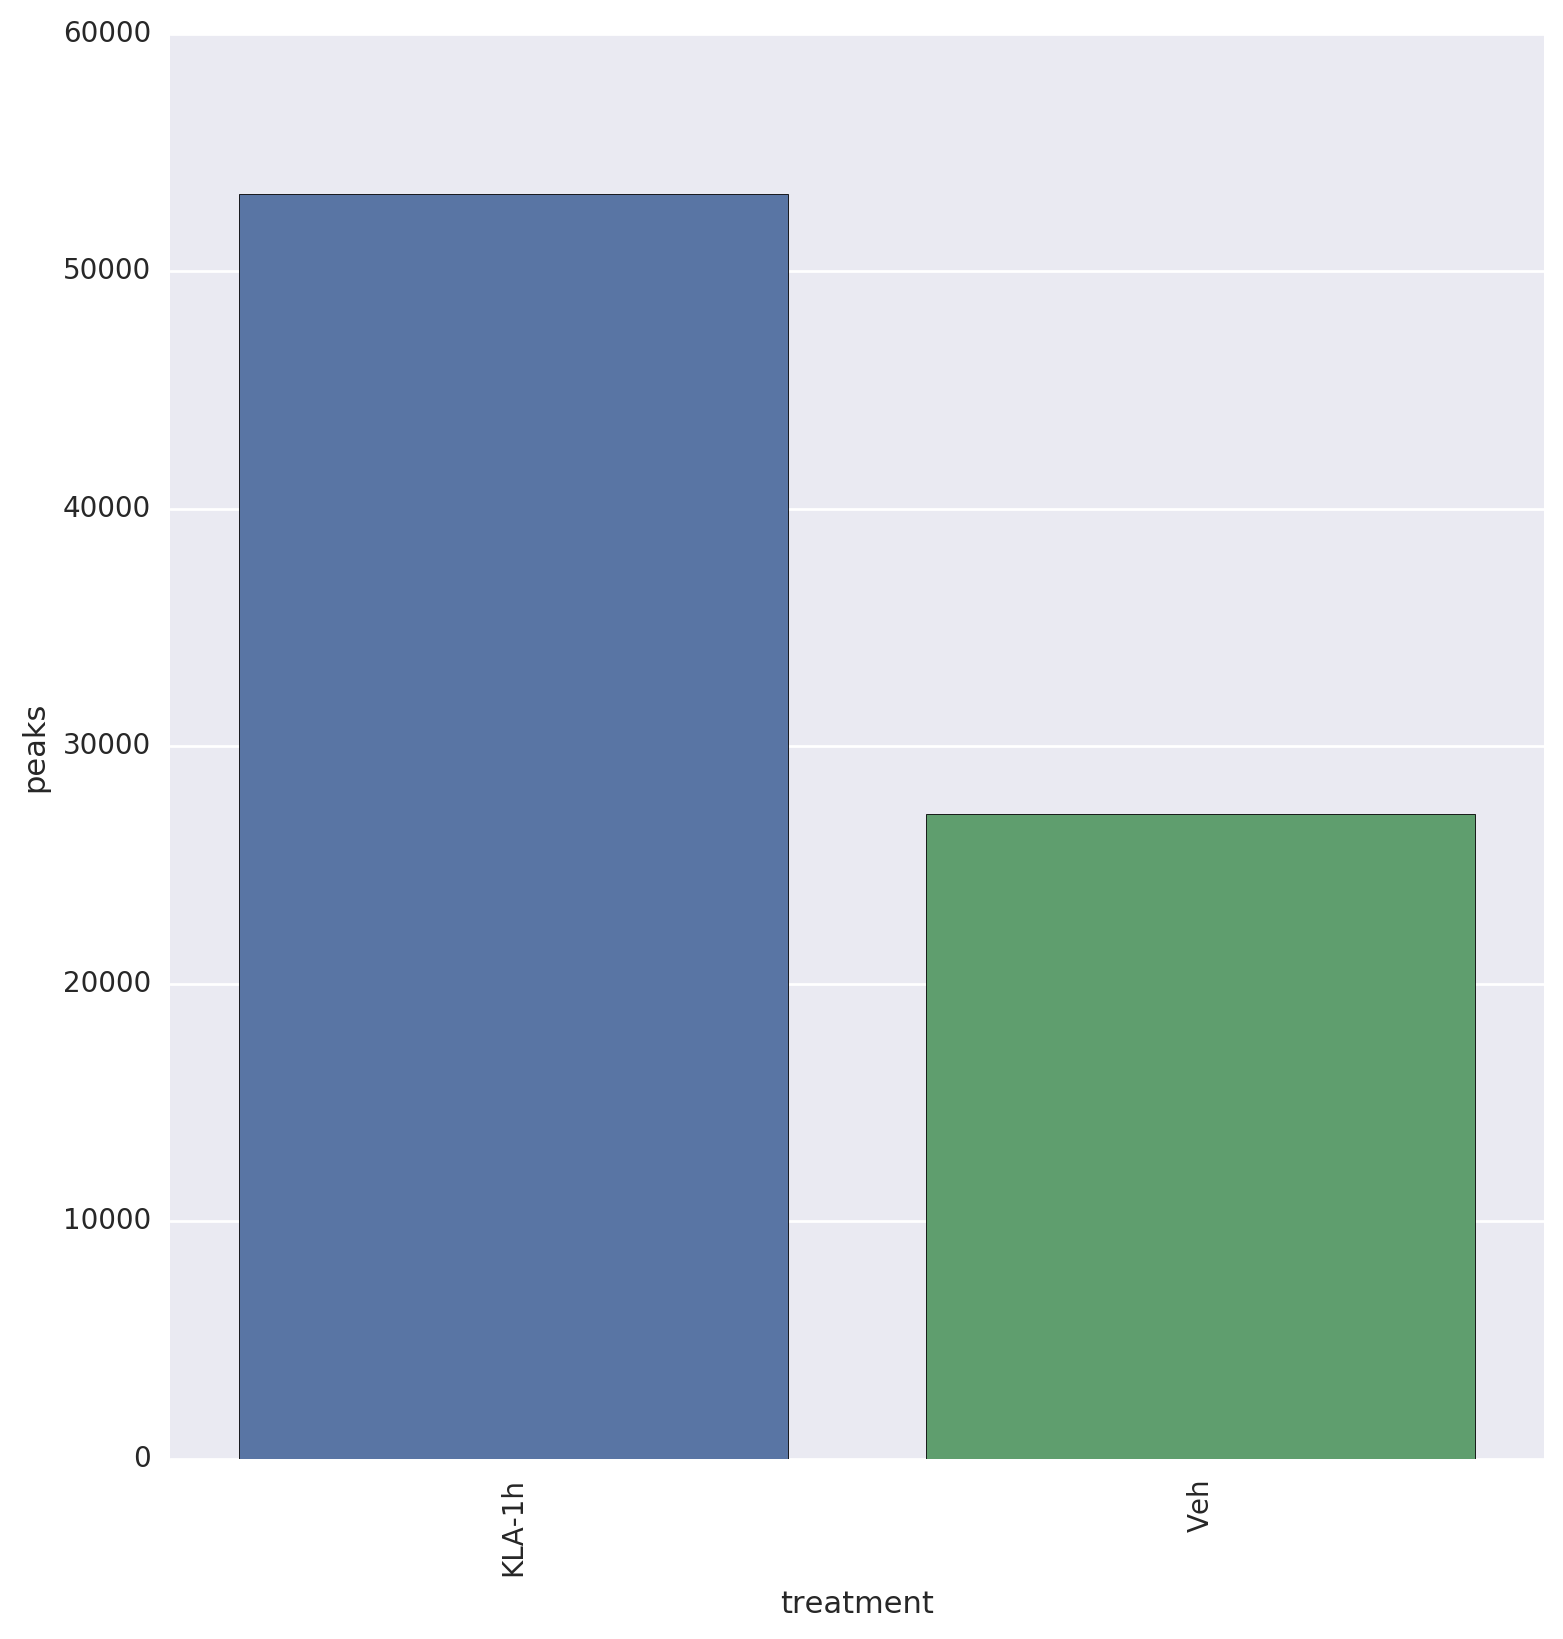

In [35]:
# pick the IDR results that have the most peaks
idrDirectory = './atac_idr/'
treatment_bestIDR_dict = {}
treatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        treatment = '_'.join(p.split('_')[:4])
        print(treatment)
        if treatment in treatment_peakNumber_dict:
            if treatment_peakNumber_dict[treatment] < numPeaks:
                treatment_peakNumber_dict[treatment] = numPeaks
                treatment_bestIDR_dict[treatment] = p
        else:
            treatment_peakNumber_dict[treatment] = numPeaks
            treatment_bestIDR_dict[treatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for treatment in treatment_peakNumber_dict.keys():
    tokens = treatment.split('_')
    strains.append(tokens[0])
    treatments.append(tokens[3])
    numPeaks.append(treatment_peakNumber_dict[treatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='treatment', y='peaks', data = idrPeak_frame, size =8, kind='bar')
plt.xticks(rotation=90);
# plt.ylim([0,30000])
    

In [39]:
if not os.path.isdir('./atac_idr_peaks/'):
    os.mkdir('./atac_idr_peaks/')
else:
    for f in os.listdir('./atac_idr_peaks/'):
        os.remove('./atac_idr_peaks/' + f)
for key in sorted(treatment_bestIDR_dict.keys()):
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    treatment = tokens[3]
    sample1 = '_'.join(tokens[:5])
    sample2 = '_'.join(tokens[7:13])
    print('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key])]))

    if treatment_bestIDR_dict[key]:
        outpath = './atac_idr_peaks/' + '_'.join([strain, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath


C57Bl6	KLA-1h	C57Bl6_Thiomac_ATAC_KLA-1h_SD	C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-1	C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-2_peaks_C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-1_peaks_idr.tsv
C57Bl6	Veh	C57Bl6_Thiomac_ATAC_Veh_SD	C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22	C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72_peaks_C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22_peaks_idr.tsv


In [40]:
target_peak_size = 100

if not os.path.isdir('./resized_peak_files'):
    os.mkdir('./resized_peak_files')
else:
    for rpf in os.listdir('./resized_peak_files'):
        os.remove('./resized_peak_files/' + rpf)

for pf in os.listdir('./atac_idr_peaks/'):
    current_peak_frame = pd.read_csv('./atac_idr_peaks/' + pf, sep='\t' )
    peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
    int_peakCenters = np.ceil(peakCenters).astype(int)
    new_starts = int_peakCenters - int(target_peak_size/2)
    new_ends = int_peakCenters + int(target_peak_size/2)
    current_peak_frame['start'] = new_starts
    current_peak_frame['end'] = new_ends
    current_peak_frame.to_csv('./resized_peak_files/' + pf, sep='\t', index=False)

In [41]:
%%capture
! mergePeaks -d given -venn venn.txt ./resized_peak_files/* > ./merged_atac_peaks.tsv

In [42]:
merged_frame = pd.read_csv('./merged_atac_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 150
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_atac_peaks_filtered_resized.tsv', sep='\t', index=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
! makeSummaryFile.py ./merged_atac_peaks_filtered_resized.tsv ./group_atac_summary.tsv ./resized_peak_files/*

Finished reading merged peak file...
Integrating scores for C57Bl6_KLA-1h
Integrating scores for C57Bl6_Veh


## Annotate Peaks

### ATAC

In [160]:
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -d ./tag_directories_atac/*/ > ./annotated_atac_peaks.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Tag Directories:
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-1/
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-2/
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22/
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 56469
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 56469
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:....................
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
		3UTR	448.0	19668322	0.085
		miRNA	2.0	

### GRO

In [161]:
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -size 500 -fragLength 0 -d ./tag_directories_gro/*/ > ./annotated_gro_peaks.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 500
	Fragment Length set to 0
	Tag Directories:
		./tag_directories_gro/C57Bl6_Thiomac_GRO_KLA-1h_SD_16-08-16-SD273/
		./tag_directories_gro/C57Bl6_Thiomac_GRO_KLA-1h_SD_16-08-16-SD274/
		./tag_directories_gro/C57Bl6_Thiomac_GRO_Veh_SD_16-08-16-SD271/
		./tag_directories_gro/C57Bl6_Thiomac_GRO_Veh_SD_16-08-16-SD272/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 56469
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 56469
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:....................
		Annotation	Number of peaks	Total siz

### Differential ATAC Peaks

In [162]:
tag_dirs = sorted(os.listdir('./tag_directories_atac/'))
treated_dirs = ' '.join(['./tag_directories_atac/' + x for x in tag_dirs if not '_Veh_' in x])
veh_dirs = ' '.join(['./tag_directories_atac/' +x for x in tag_dirs if  '_Veh_' in x])
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -raw -d $veh_dirs $treated_dirs > ./annotated_atac_peaks_raw.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Will NOT normalize tag counts
	Tag Directories:
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_Veh_SD_16-03-22-and-16-04-11-SD72
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-1
		./tag_directories_atac/C57Bl6_Thiomac_ATAC_KLA-1h_SD_16-03-22-2
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 56469
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 56469
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:....................
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
		3UTR	448.0	

In [163]:
with open('./annotated_atac_peaks_raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[19:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./annotated_atac_peaks_raw.tsv $condition_string -AvsA > edgeR_atac_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected annotatePeaks.pl file
	Output Stats Veh vs. KLA-1h:
		Total Genes: 56469
		Total Up-regulated in KLA-1h vs. Veh: 12317 (21.812%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. Veh: 7399 (13.103%) [log2fold<-1, FDR<0.05]



## Differentially Expressed Genes

In [72]:
tag_dirs = sorted(os.listdir('./tag_directories_rna/'))
treated_dirs = ' '.join(['./tag_directories_rna/' + x for x in tag_dirs if not '_Veh' in x])
veh_dirs = ' '.join(['./tag_directories_rna/' +x for x in tag_dirs if  '_Veh' in x])

In [73]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -noadj -d $veh_dirs $treated_dirs > raw.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09
		./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
		./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
		./tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09
		./tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-17
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-17
	Printing output
		Printed 24453 of 34711 repeats (expression >= -1e+20)


In [74]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -rpkm -d $veh_dirs $treated_dirs > rpkm.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09
		./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
		./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
		./tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09
		./tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-17
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09
	Calculating read coverage for ./tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-17
		Normalizing...
		Normalizing...
		Normalizing...
		Normalizing...
		Normalizing...
	Printing output
		Printe

In [75]:
with open('./raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[8:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./raw.tsv $condition_string > edgeR_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Veh vs. KLA-1h:
		Total Genes: 24453
		Total Up-regulated in KLA-1h vs. Veh: 163 (0.667%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. Veh: 4 (0.016%) [log2fold<-1, FDR<0.05]



## Calculate Motif Scores

In [49]:
%%bash
# extract sequences for analysis
pos2bed.pl ./merged_atac_peaks_filtered_resized.tsv > ./tmp
tail -n +2 ./tmp > ./merged_atac_peaks_filtered_resized.bed
rm tmp


	Converted 56469 peaks total



In [50]:
!/gpfs/data01/glasslab/home/jtao/code/tba/extract_sequences.py ./merged_atac_peaks_filtered_resized.bed mm10 ./merged_atac_peaks_filtered_resized.fasta

reading genome mm10


### All Motif Scores

In [ ]:
# calculate motif scores
!rm -r ./motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/calculate_all_motif_scores.py -num_procs 28 ./merged_atac_peaks_filtered_resized.fasta ./motif_scores /gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/*motif 

rm: cannot remove ‘./motif_scores’: No such file or directory
AP-2_1_merged calculation time: 459.1206257343292
CTCF calculation time: 448.63721895217896
CP2-related_1_merged calculation time: 462.4680016040802
Bcl6 calculation time: 479.20519495010376
BCL6B calculation time: 482.94911313056946
E2F-related_2_merged calculation time: 457.9318928718567
DMRT3 calculation time: 467.9760615825653
E2F-related_3_merged calculation time: 461.35321855545044
Bach1::Mafk calculation time: 487.77032947540283
ATF4 calculation time: 502.0193283557892
Arid5a calculation time: 498.5609531402588
CREB-related_1_merged calculation time: 481.8361566066742
BARHL2 calculation time: 498.25181818008423
AP-2_2_merged calculation time: 507.17067074775696
Arid3a calculation time: 502.9049024581909
Brachyury-related_1_merged calculation time: 493.04406452178955
EBF1 calculation time: 466.5537440776825
Ddit3::Cebpa calculation time: 478.894544839859
Dux calculation time: 477.6055054664612
CENPB calculation time: 4

### Top Motif Scores

In [ ]:
# calculate motif scores
!rm -r ./top_motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/calculate_motif_scores.py -num_procs 28 ./merged_atac_peaks_filtered_resized.fasta ./top_motif_scores /gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/*motif 

rm: cannot remove ‘./motif_scores’: No such file or directory
DMRT3 calculation time: 360.2284815311432
CP2-related_1_merged calculation time: 369.02230072021484
Brachyury-related_1_merged calculation time: 376.26801347732544
ATF4 calculation time: 391.7348816394806
EBF1 calculation time: 359.29960203170776
CTCF calculation time: 371.6599955558777
E2F-related_2_merged calculation time: 367.2333173751831
Bcl6 calculation time: 390.3344051837921
BCL6B calculation time: 393.72959566116333
Ahr::Arnt calculation time: 402.1710674762726
E2F-related_3_merged calculation time: 374.29560589790344
AP-2_1_merged calculation time: 409.707248210907
Ddit3::Cebpa calculation time: 384.4718368053436
Bach1::Mafk calculation time: 401.0715899467468
CEBPA calculation time: 396.7222349643707
CREB1 calculation time: 392.1004765033722
Arid5a calculation time: 407.82206678390503
E2F-related_1_merged calculation time: 386.09208393096924
CENPB calculation time: 399.3982057571411
Dux calculation time: 390.49075

## Read in Data

### Peak Data

In [144]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['chr'] + ':' + (summary_frame['start'] -1).astype(str) + '-' + summary_frame['end'].astype(str)

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

columns = summary_frame.columns.values
columns = [x.replace('C57Bl6_','') for x in columns]
summary_frame.columns = columns

### ATAC Tag Data

In [164]:
# read in annotated frame
annotated_frame = pd.read_csv('./annotated_atac_peaks.tsv', sep='\t')
annotated_frame.index = annotated_frame['Chr'] + ':' + (annotated_frame['Start'] -1).astype(str) + '-' + annotated_frame['End'].astype(str)

# get promoter associated peaks and associated gene names
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]

columns = list(annotated_frame.columns.values)
columns = columns[:4] + ['Annotation', 'Gene Name'] + [x for x in columns[1:] if 'Tag Count' in x]
annotated_frame = annotated_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-2].split(' ')[0] if '/' in x else x for x in columns]
annotated_frame.columns = columns

annotated_mean_atac_frame = annotated_frame[[]]

treatments = set([x.split('_')[3] for x in annotated_frame.columns if '_' in x])
print('treatment loop')
for treatment in treatments:
    print(treatment)
    treatment_cols = [x for x in columns if treatment in x]
    annotated_mean_atac_frame[treatment] = annotated_frame[treatment_cols].mean(axis=1).values

promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
intergenic_ids = annotated_frame[annotated_frame['Annotation'].str.contains('Intergenic')].index.values

treatment loop
Veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KLA-1h


### GRO Data

In [168]:
# read in annotated frame
gro_frame = pd.read_csv('./annotated_gro_peaks.tsv', sep='\t')
gro_frame.index = gro_frame['Chr'] + ':' + (gro_frame['Start'] -1 +(250-75)).astype(str) + '-' + (gro_frame['End']-250+75).astype(str)

# get promoter associated peaks and associated gene names
gro_frame['Annotation'] = [x.split(' ')[0] for x in gro_frame['Annotation'].astype(str)]

columns = list(gro_frame.columns.values)
columns = columns[:4] + ['Annotation', 'Gene Name'] + [x for x in columns[1:] if 'Tag Count' in x]
gro_frame = gro_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-2].split(' ')[0] if '/' in x else x for x in columns]
gro_frame.columns = columns

annotated_mean_gro_frame = gro_frame[[]]

treatments = set([x.split('_')[3] for x in gro_frame.columns if '_' in x])
print('treatment loop')
for treatment in treatments:
    print(treatment)
    treatment_cols = [x for x in columns if treatment in x]
    annotated_mean_gro_frame[treatment] = gro_frame[treatment_cols].mean(axis=1).values

treatment loop
Veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KLA-1h


### Expression Data

In [83]:
rpkm_frame = pd.read_csv('./rpkm.tsv', sep='\t')
columns = rpkm_frame.columns.values
columns[0] = 'Refseq'
columns[7] = 'Gene'
rpkm_frame.columns = columns
rpkm_frame['All Gene Names'] = rpkm_frame['Gene'].values
rpkm_frame['Gene'] = [x.split('|')[0] for x in rpkm_frame['Gene'].values]
rpkm_frame.index = rpkm_frame['Gene'].values
rpkm_frame.drop('strand', axis=1, inplace=True)
rpkm_frame.drop('Length', axis=1, inplace=True)
rpkm_frame.drop('Copies', axis=1, inplace=True)
conditions = set(sorted([x.split('/')[-1].split('_')[3] for x in rpkm_frame.columns if 'tag_directories' in x]))
rpkm_mean_frame = rpkm_frame[['Refseq', 'Gene', 'All Gene Names']]
for condition in conditions:
    current_cols = [x for x in rpkm_frame.columns if condition in x]
    mean_vals = rpkm_frame[current_cols].mean(axis=1)
    rpkm_mean_frame[condition] = mean_vals
    

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Diff Expression Data

In [84]:
diff_expression_frame = pd.read_csv('./edgeR_out.tsv', sep='\t')
columns = diff_expression_frame.columns.values
columns[0] = 'refseq'
columns[7] = 'gene'

columns = [x.lower() for x in columns]
diff_expression_frame.columns = columns

diff_expression_frame = diff_expression_frame.ix[:,['refseq', 'chr', 'start', 'end', 'gene'] + [x for x in diff_expression_frame.columns if 'vs.' in x]]
diff_expression_frame['gene'] = [x.split('|')[0] for x in diff_expression_frame['gene'].values]

### Motifs

In [90]:
pseudocount = 0.001
motif_file_path = '/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/'
all_motifs = []

for m in os.listdir(motif_file_path):
    if '.motif' in m:
        motif = read_motif_file(motif_file_path + '/' + m, pseudocount)
        all_motifs.append(motif)
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])

fasta_path = './merged_atac_peaks_filtered_resized.fasta'

sequence_list, id_list = read_fasta(fasta_path)

# convert strings to arrays
sequence_array_list = convert_sequences_to_array(sequence_list)

motif_size_dict = {}
for motif in all_motifs:
    name = motif[0]
    size = motif[1].shape[0]
    if '.' in name:
        name = '.'.join(name.split('.')[:-1])
    motif_size_dict[name] = size

motif_names = sorted(motif_size_dict.keys())

### Identify Expressed Transcription Factors

In [91]:
gene_motif_dict = {}
with open('/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/clustered_motifs/motifGene.txt') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split()
    motif = tokens[0]
    genes = tokens[1].split('|')
    if motif in motif_size_dict:
        for g in genes:
            if g in gene_motif_dict:
                gene_motif_dict[g.upper()].append(motif)
            else:
                gene_motif_dict[g.upper()] = [motif]

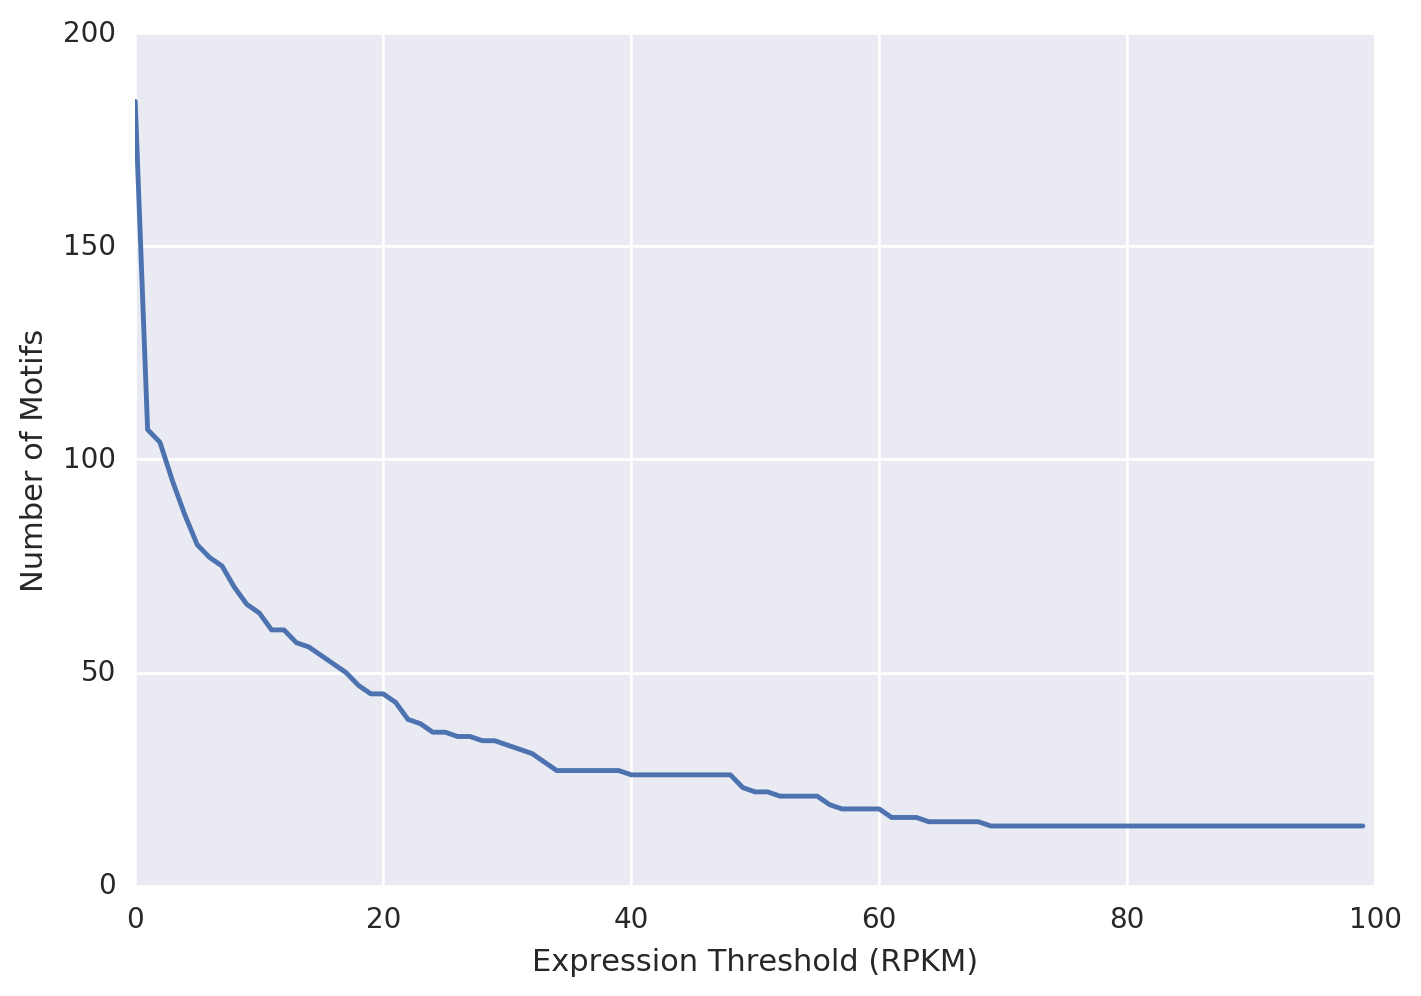

In [92]:
expression_threshold = 16
# thresholds = [1,2,4,8,16,32,64,128]
thresholds = range(100)
num_motifs = []
for expression_threshold in thresholds:
    motifs_at_threshold = []
    gene_names = rpkm_mean_frame[
        rpkm_mean_frame.ix[:,2:].max(axis=1) >= expression_threshold
                    ].ix[:,'All Gene Names'].values
    for gn in gene_names:
        genes = gn.upper().split('|')
        for g in genes:
            if g in gene_motif_dict:
                motifs_at_threshold += gene_motif_dict[g]
    motifs_at_threshold = sorted(set(motifs_at_threshold))
    num_motifs.append(len(motifs_at_threshold))
plt.plot(thresholds, num_motifs) 
plt.xlabel('Expression Threshold (RPKM)')
plt.ylabel('Number of Motifs')

In [93]:
expression_threshold = 20
motifs_to_include = []
gene_names = rpkm_mean_frame[
    rpkm_mean_frame.ix[:,2:].max(axis=1) >= expression_threshold
                ].ix[:,'All Gene Names'].values
for gn in gene_names:
    genes = gn.upper().split('|')
    for g in genes:
        if g in gene_motif_dict:
            motifs_to_include += gene_motif_dict[g]
motifs_to_include = sorted(set(motifs_to_include))
print(len(set(motifs_to_include)))

45


### Motif Scores

#### All Motif Scores

In [94]:
motif_score_dict = {}
motif_score_rc_dict = {}
for f in sorted([x for x in os.listdir('./motif_scores') if x.split('.')[0] in motifs_to_include]):
    motif_name = f.split('.')[0]
    if 'rc' in f:
        print('reading', motif_name)
        motif_score_rc_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))
    else:
        motif_score_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))

reading ATF4
reading Arid3a
reading CEBP-related_1_merged
reading CEBP-related_2_merged
reading CENPB
reading CREB-related_1_merged
reading Ddit3::Cebpa
reading E2F-related_1_merged
reading EGR1
reading Ets-related_1_merged
reading Ets-related_2_merged
reading Forkhead_1_merged
reading HD-CUT_1_merged
reading Hairy-related_1_merged
reading IRF1
reading IRF2
reading Interferon-regulatory_1_merged
reading Jun-related_1_merged
reading Jun-related_2_merged
reading MAFG
reading MAFG::NFE2L1
reading Maf-related_1_merged
reading More_1_merged
reading NF-kappaB-related_1_merged
reading NF-kappaB-related_2_merged
reading NFYA
reading NRF1
reading Nfe2l2
reading Nr1h3::Rxra
reading PAS_1_merged
reading PPARG
reading PRDM1
reading Paired-related_3_merged
reading Regulators_1_merged
reading STAT_1_merged
reading Steroid_3_merged
reading TALE-type_1_merged
reading TBrain-related_1_merged
reading Three-zinc_3_merged
reading XBP1
reading YY1
reading ZBTB18
reading ZBTB7A
reading bHLH-ZIP_1_merged
rea

#### Top Motif Scores

In [95]:
topMotifScore_frame = pd.read_csv('./top_motif_scores/merged_atac_peaks_filtered_resized_motif_scores.tsv', 
                    sep='\t',
                    index_col= 0)

## Find Symmetric Motifs

In [96]:
num_sequence_to_sample = 100
num_seqs = len(sequence_array_list)
mean_pearsons = []
motif_symmetryPearson_dict = {}
for motif in sorted(motif_score_dict.keys()):
    
    pearsons = []
    for i in range(num_sequence_to_sample):
        index = np.random.randint(0,num_seqs)

        forward_scores = motif_score_dict[motif][index]
        reverse_scores = motif_score_rc_dict[motif][index]

        pearson, pval = scipy.stats.pearsonr(forward_scores, reverse_scores)
        pearsons.append(pearson)
    mean_pearson = np.mean(pearsons)
    mean_pearsons.append(mean_pearson)
    motif_symmetryPearson_dict[motif] = mean_pearson
symmetric_motifs = [x for x in motif_symmetryPearson_dict if motif_symmetryPearson_dict[x] > 0.8]



## Find Frequent Patterns

In [97]:
id_motifScore_forward_dict = {}
for i in range(len(id_list)):
    current_id = id_list[i]
    current_dict = {}
    for motif in motifs_to_include:
        if motif in motif_score_dict:
            current_dict[motif] = motif_score_dict[motif][i]
    id_motifScore_forward_dict[current_id] = current_dict

In [98]:
id_motifScore_reverse_dict = {}
for i in range(len(id_list)):
    current_id = id_list[i]
    current_dict = {}
    for motif in motifs_to_include:
        if motif in motif_score_rc_dict:
            current_dict[motif] = motif_score_rc_dict[motif][i]
    id_motifScore_reverse_dict[current_id] = current_dict

In [99]:
index = 1
seq_array = sequence_array_list[index]
forward_score_dict = id_motifScore_forward_dict[id_list[index]]
reverse_score_dict = id_motifScore_reverse_dict[id_list[index]]
graph, paths, paths_nodata = calc_multi_motif_sequence(seq_array, 
                              forward_score_dict, 
                              reverse_score_dict, 
                              motif_size_dict,
                              score_threshold = 5,
                              distance_threshold = 200,
                              symmetric_motifs = symmetric_motifs
                             )
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 19
Number of edges: 29
Average in degree:   1.5263
Average out degree:   1.5263


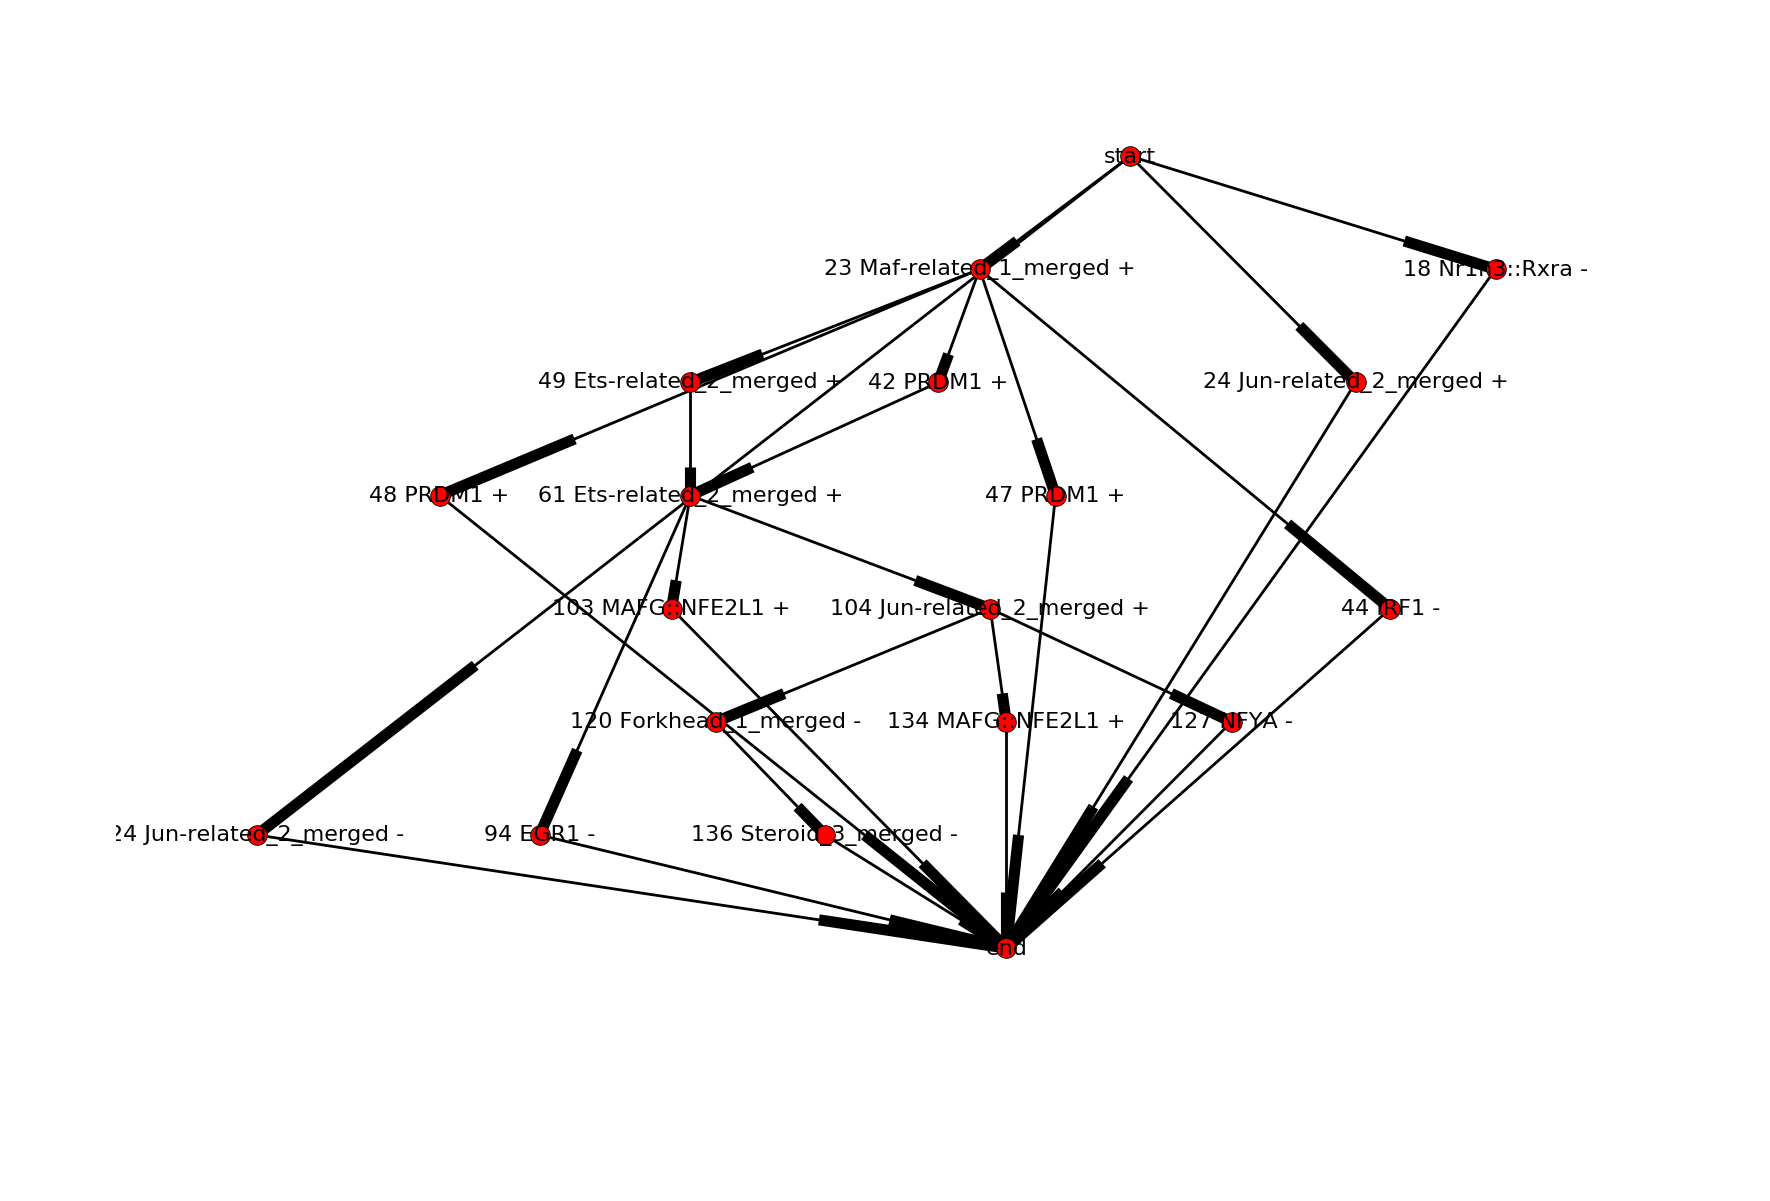

In [100]:
nx.draw(graph,
        node_size=50,
        with_labels=True,
        font_size = 8,
        pos=graphviz_layout(graph, prog = 'dot'))



In [ ]:
id_pathList_dict = {}
counter = 0
for index in range(len(id_list)):
    if index % 100 ==0: 
        print(index)
    seq_id = id_list[index]
    seq_array = sequence_array_list[index]
    forward_score_dict = id_motifScore_forward_dict[seq_id]
    reverse_score_dict = id_motifScore_reverse_dict[seq_id]
    result = calc_multi_motif_sequence(seq_array, 
             forward_score_dict, 
             reverse_score_dict, 
             motif_size_dict,
             score_threshold = 5,
             distance_threshold = 200,
             symmetric_motifs = symmetric_motifs
             )
    graph, paths_with_data, paths_without_data = result
    if len(paths_without_data) > 1:
        id_pathList_dict[seq_id] = paths_without_data
    else:
        counter +=1
print(counter)

0
100
Too many paths!!!
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


In [ ]:
id_pathList_intergenic_dict = {x:id_pathList_dict[x] for x in intergenic_ids if x in id_pathList_dict}



In [303]:
min_support_level = 500

frequent_intergenic_patterns = motif_prefix_span([], id_pathList_intergenic_dict, min_support_level)

In [304]:
len(id_pathList_intergenic_dict)

14018

In [305]:
# sequence_pattern_promoter_table = create_pattern_sequence_table(frequent_promoter_patterns, id_pathList_promoter_dict)
start = time.time()
sequence_pattern_intergenic_table = create_pattern_sequence_table(frequent_intergenic_patterns, 
                                                       id_pathList_intergenic_dict,
                                                       )
print('total time', time.time() - start)

done searching for MAFG::NFE2L1 - 68.32255363464355
done searching for MAFG::NFE2L1 + 128.93127131462097
done searching for MAFG::NFE2L1 - * MAFG::NFE2L1 + 215.10510349273682
done searching for MAFG::NFE2L1 - * MAFG::NFE2L1 - 242.70600771903992
done searching for MAFG::NFE2L1 - * Jun-related_2_merged + 247.97216629981995
done searching for MAFG::NFE2L1 - * Jun-related_2_merged - 250.77107167243958
done searching for MAFG::NFE2L1 - * Jun-related_1_merged - 298.9903554916382
done searching for MAFG::NFE2L1 - * PAS_1_merged + 306.9725739955902
done searching for MAFG::NFE2L1 - * STAT_1_merged + 318.03052043914795
done searching for MAFG::NFE2L1 + * MAFG::NFE2L1 - 314.4259731769562
done searching for MAFG::NFE2L1 - * Hairy-related_1_merged - 336.7847738265991
done searching for MAFG::NFE2L1 - * MAFG::NFE2L1 + * MAFG::NFE2L1 + 340.2513563632965
done searching for MAFG::NFE2L1 - * STAT_1_merged - 342.35859870910645
done searching for MAFG::NFE2L1 + * Jun-related_1_merged + 334.6147360801697


In [306]:
sequence_pattern_intergenic_table.to_pickle('./sequence_pattern_intergenic_table.pickle')

In [307]:
sequence_pattern_intergenic_table.shape

(14018, 429)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


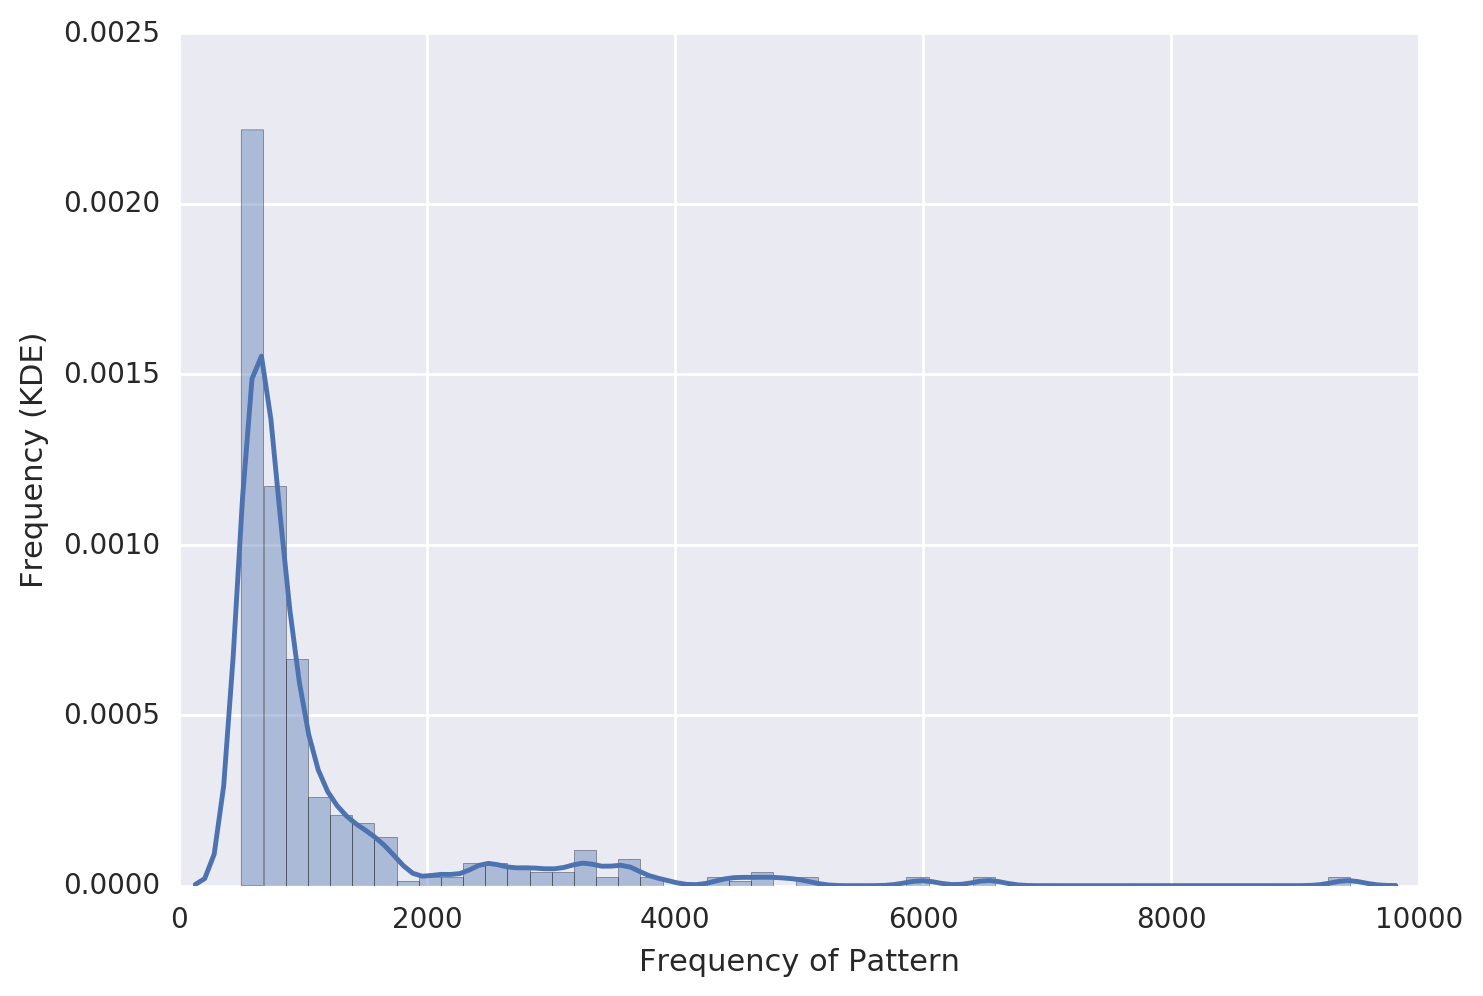

In [308]:
sns.distplot(sequence_pattern_intergenic_table.sum())
plt.xlabel('Frequency of Pattern')
plt.ylabel('Frequency (KDE)')

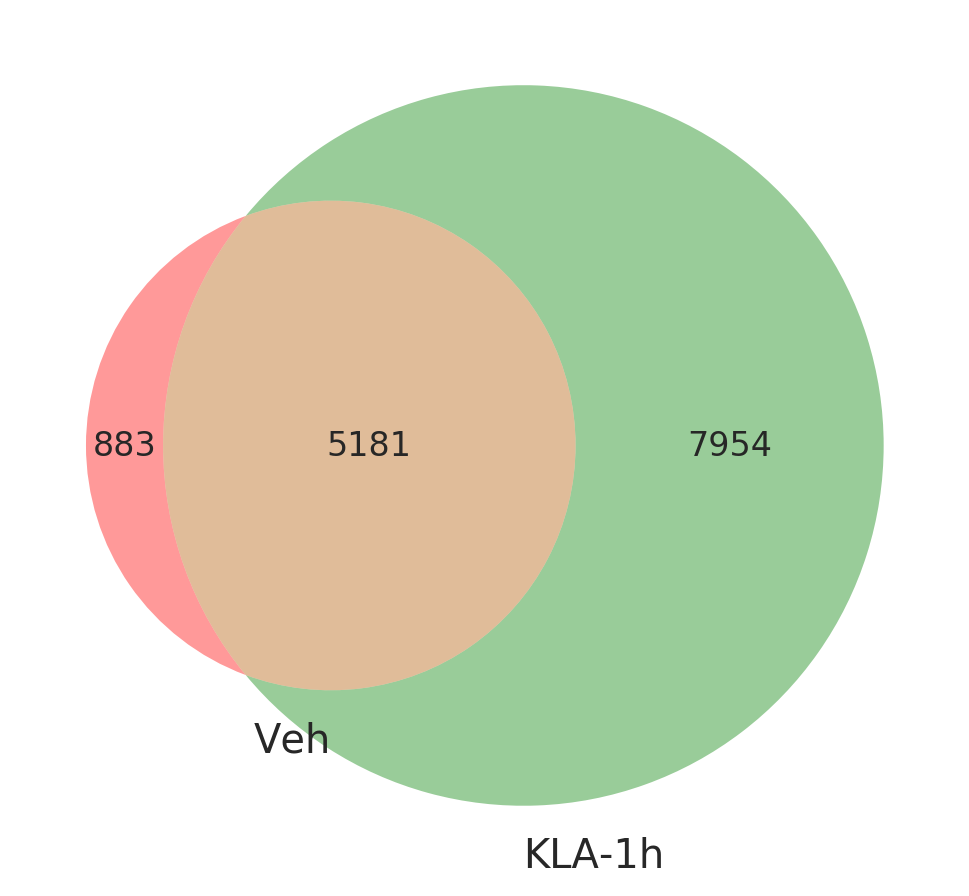

In [309]:
kla_ids = [x for x in summary_frame[summary_frame['KLA-1h'] > 0].index.values if x in id_pathList_intergenic_dict]
veh_ids = [x for x in summary_frame[summary_frame['Veh'] > 0].index.values if x in id_pathList_intergenic_dict]
matplotlib_venn.venn2([set(veh_ids), set(kla_ids)], set_labels=['Veh', 'KLA-1h'])

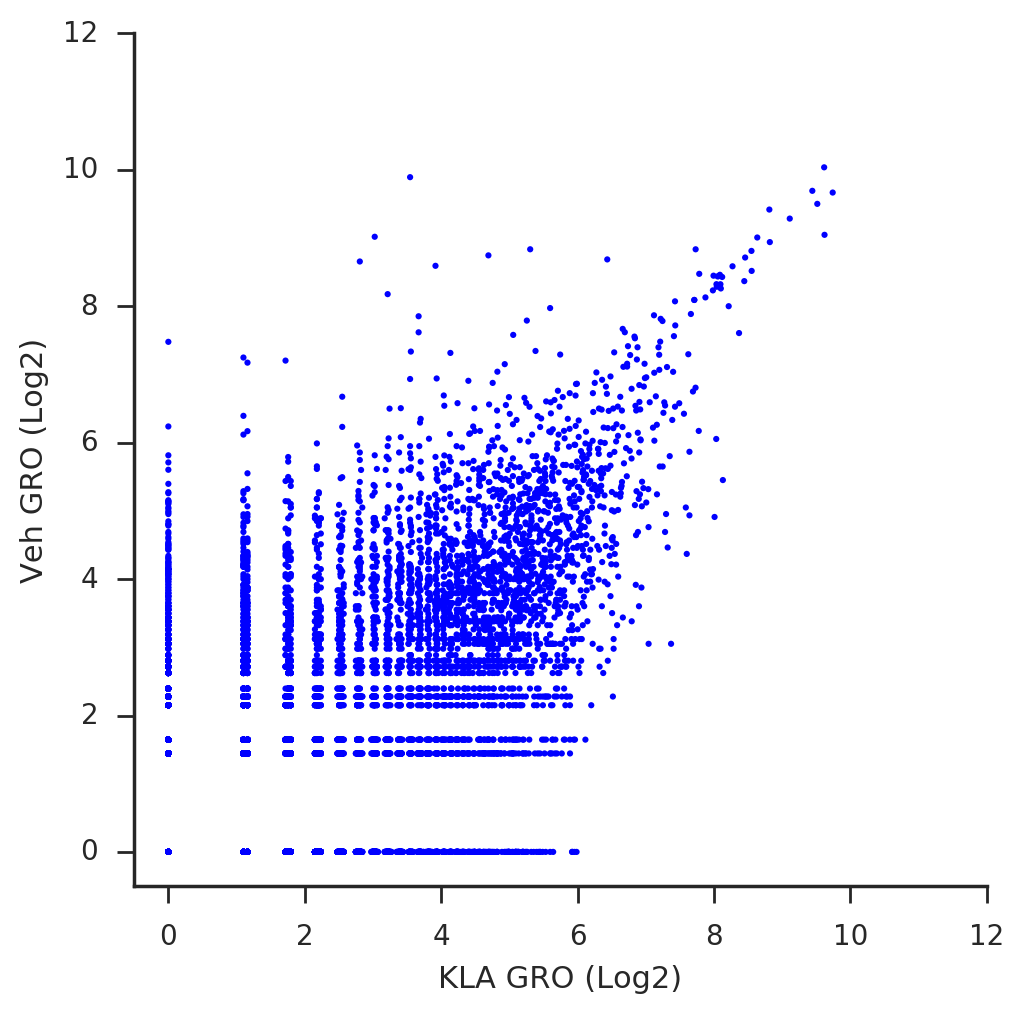

In [423]:
with sns.axes_style('ticks'):
    has_rep_intergenic_ids = sorted(id_pathList_intergenic_dict.keys())
    plt.scatter(np.log2(annotated_mean_gro_frame.ix[has_rep_intergenic_ids, 'Veh']+1),
                np.log2(annotated_mean_gro_frame.ix[has_rep_intergenic_ids, 'KLA-1h']+1),
                edgecolor='None',
                s=5)
    plt.xlim(-0.5,12)
    plt.ylim(-0.5,12)
    plt.gca().set_aspect(1.0)
    sns.despine()
    plt.xlabel('KLA GRO (Log2)')
    plt.ylabel('Veh GRO (Log2)')

In [390]:
log_ratios = np.log2((annotated_mean_gro_frame.ix[has_rep_intergenic_ids, 'KLA-1h']+1) /(annotated_mean_gro_frame.ix[has_rep_intergenic_ids, 'Veh']+1))
differences = annotated_mean_gro_frame.ix[has_rep_intergenic_ids, 'KLA-1h'] -(annotated_mean_gro_frame.ix[has_rep_intergenic_ids, 'Veh'])
kla_levels = np.log2(annotated_mean_gro_frame.ix[has_rep_intergenic_ids, 'KLA-1h']+1) 

In [391]:
id_logRatio_dict = dict(zip(log_ratios.index.values, log_ratios.values))
id_difference_dict = dict(zip(differences.index.values, differences.values))
id_klaLevel_dict = dict(zip(kla_levels.index.values, kla_levels.values))

## Correlate Individual Motifs to Change in GRO Levels

AP-2_1_merged 0.0579963267168
AP-2_2_merged 0.0558104014054
CENPB 0.061777009494
E2F-related_1_merged 0.0748558501437
EGR1 0.0824654116049
HINFP 0.0689478246022
Hairy-related_1_merged 0.0500326068966
Klf12 0.081902707149
NF-kappaB-related_2_merged 0.0698129192107
NRF1 0.0763217433914
PAS_1_merged 0.0523620161173
Three-zinc_1_merged 0.094967077399
Three-zinc_2_merged 0.115004786882
Three-zinc_3_merged 0.0774392864052
ZBTB33 0.0879297237184
ZNF740 0.0920986877055
Zfx 0.0690171357182


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


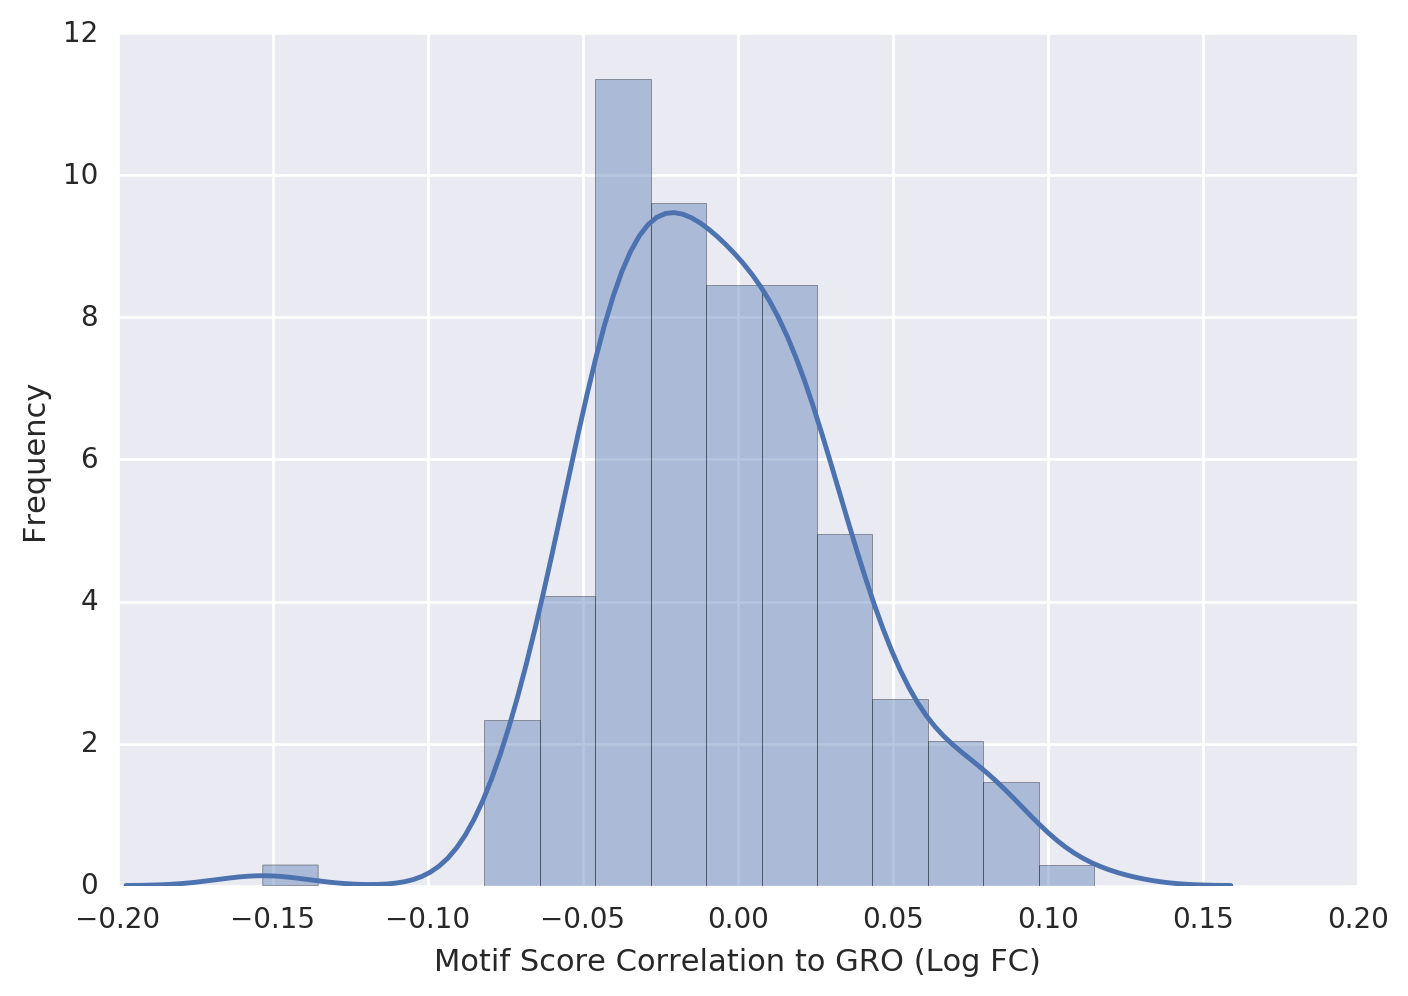

In [392]:
correlations = []



for motif in topMotifScore_frame.columns.values:
    pearson, pval = scipy.stats.pearsonr(topMotifScore_frame.ix[has_rep_intergenic_ids,motif], kla_levels)
#     pearson, pval = scipy.stats.pearsonr(topMotifScore_frame.ix[nonzero_indices,motif], log_ratios[nonzero_indices])
#     print(motif, pearson)
    correlations.append(pearson)
    if pearson > 0.05:
        print(motif, pearson)
sns.distplot(correlations)
plt.xlabel('Motif Score Correlation to GRO (Log FC)')
plt.ylabel('Frequency')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


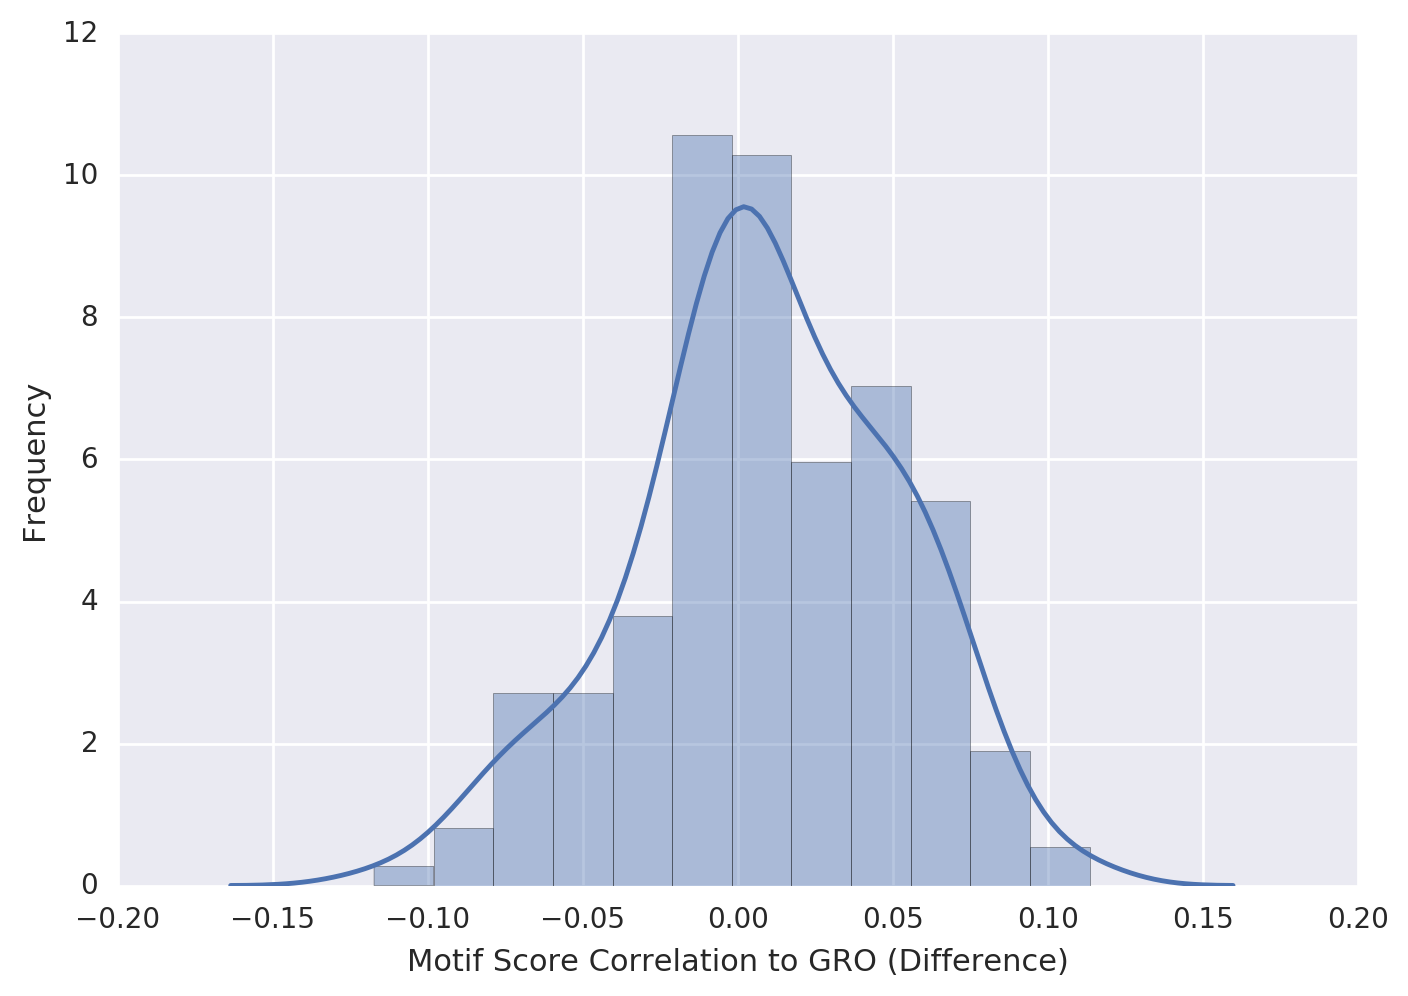

In [393]:
correlations = []
for motif in topMotifScore_frame.columns.values:
    pearson, pval = scipy.stats.spearmanr(topMotifScore_frame.ix[has_rep_intergenic_ids,motif], differences)
#     pearson, pval = scipy.stats.pearsonr(topMotifScore_frame.ix[nonzero_indices,motif], log_ratios[nonzero_indices])
#     print(motif, pearson)
    correlations.append(pearson)
sns.distplot(correlations)
plt.xlabel('Motif Score Correlation to GRO (Difference)')
plt.ylabel('Frequency')

## Regression Tree

In [316]:
from sklearn import svm

In [317]:
from sklearn import ensemble

In [409]:
performance_regElement_list = []
regressor = tree.DecisionTreeRegressor(
                                       criterion='mse',
                                       max_depth=4, 
#                                        min_samples_split=10,
#                                        min_samples_leaf=50,
                                 )
# regressor = sklearn.linear_model.LinearRegression()

indices = sequence_pattern_intergenic_table.index.values
indices = nonzero_indices
assignments = np.random.choice(2, len(indices))
training_indices = []
test_indices = []
for i in range(len(indices)):
    if assignments[i]==1:
        test_indices.append(indices[i])
    else:
        training_indices.append(indices[i])


print(len(training_indices), len(test_indices))
training_labels = pd.Series([id_logRatio_dict[x] for x in training_indices],
                   index= training_indices)
test_labels = pd.Series([id_logRatio_dict[x] for x in test_indices],
                   index= test_indices)

regressor.fit(sequence_pattern_intergenic_table.ix[training_indices,:], training_labels)
# print(regressor.score(sequence_pattern_intergenic_table.ix[test_indices,:], test_labels))
print(scipy.stats.pearsonr(test_labels, regressor.predict(sequence_pattern_intergenic_table.ix[test_indices,:])))
print(scipy.stats.pearsonr(training_labels, regressor.predict(sequence_pattern_intergenic_table.ix[training_indices,:])))


# plt.scatter(test_labels, regressor.predict(sequence_pattern_intergenic_table.ix[test_indices,:]))

4673 4639
(0.13773951104593257, 4.3469230903584114e-21)
(0.21588310275879657, 2.1006482971041676e-50)


In [410]:
tree.export_graphviz(regressor, 
                     out_file='tree_intergenic.dot',
                     feature_names = sequence_pattern_intergenic_table.columns.values)

!dot -Tpdf tree_intergenic.dot -o tree_intergenic.pdf

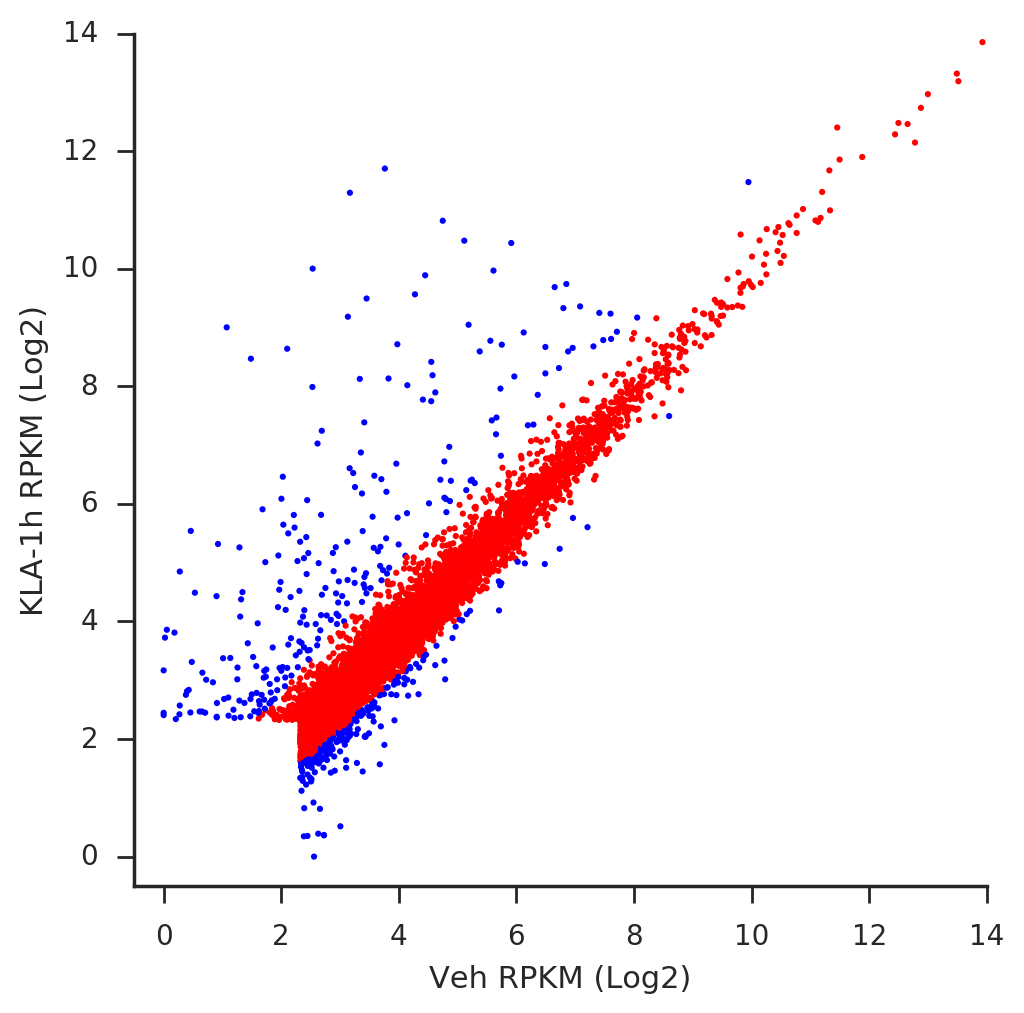

In [422]:
tuples = list(zip(rpkm_mean_frame['Veh'], rpkm_mean_frame['KLA-1h']))
xvals = np.array([x[0] for x in tuples if max(x) >=4])
yvals = np.array([x[1] for x in tuples if max(x) >=4])
colors = ['blue' if (x[0]/x[1] >= 2 or x[1]/x[0] >=2) else 'red' for x in tuples if max(x) >=4]
with sns.axes_style('ticks'):
    plt.scatter(np.log2(xvals+1), 
                np.log2(yvals+1),
                edgecolor = 'None',
                s=5,
                c=colors)
    ax = plt.gca()
    plt.xlim(-0.5,14)
    plt.ylim(-0.5,14)
    ax.set_aspect(1.0)
    sns.despine()
    
    plt.xlabel('Veh RPKM (Log2)')
    plt.ylabel('KLA-1h RPKM (Log2)')
    plt.savefig('/gpfs/data01/glasslab/home/jtao/veh_vs_kla_rpkm.pdf', bbox_inches='tight')